In [3]:
import pandas as pd
import numpy as np
# from surprise import Dataset, Reader, SVD
# from surprise.model_selection import train_test_split, cross_validate
# from surprise.accuracy import rmse
import matplotlib.pyplot as plt

In [4]:
review_sentiment_df = pd.read_csv('output/LSTM_predictions.csv')
review_sentiment_df

,Unnamed: 0,location_id,location_name,trip_type,rating,helpful_voting,review_text,actual_sentiment,predicted_sentiment
0,8,2273363.0,Wat Rajapradit Sathitmahasimaram Rajaworavihara,NONE,5.0,2.0,One of the least crowded temples but very beau...,2,1
1,14,311043.0,Wat Phra Chetuphon,Couples,5.0,0.0,"The designs, the Buddhas, and other figures fe...",1,1
2,17,317504.0,Temple Of Dawn (Wat Arun),Solo travel,5.0,15.0,"Known as Temple of Dawn, I went to this temple...",0,0
3,19,317504.0,Temple Of Dawn (Wat Arun),Family,4.0,0.0,I have to admit that this is a place i have al...,0,0
4,23,456322.0,Wat Umong,Family,5.0,0.0,The visit to this temple was a good pick for u...,1,2
...,...,...,...,...,...,...,...,...,...
1718,8581,NaN,NaN,NaN,NaN,NaN,NaN,2,2
1719,8589,NaN,NaN,NaN,NaN,NaN,NaN,2,2
1720,8602,NaN,NaN,NaN,NaN,NaN,NaN,2,2
1721,8609,NaN,NaN,NaN,NaN,NaN,NaN,1,2


In [3]:
# ----------------------------
# 1. การเตรียมข้อมูล
# ----------------------------

# สมมติว่าเรามีข้อมูลดังนี้
data = {
    'tourist_id': [1, 2, 3, 4, 5],
    'place_id': [101, 102, 103, 104, 105],
    'score': [4, 5, 3, 4, 2],
    'sentiment': ['positive', 'positive', 'neutral', 'negative', 'positive']
}

df = pd.DataFrame(data)

# แปลง sentiment เป็นตัวเลข
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
df['sentiment_score'] = df['sentiment'].map(sentiment_mapping)

# คำนวณ rating
df['rating'] = (df['score'] * 20) + (df['sentiment_score'] * 10)
df['rating'] = df['rating'].clip(1, 100)  # เพื่อให้ค่าอยู่ระหว่าง 1-100

print("Data with calculated ratings:")
print(df[['tourist_id', 'place_id', 'score', 'sentiment', 'rating']])

Data with calculated ratings:
   tourist_id  place_id  score sentiment  rating
0           1       101      4  positive      90
1           2       102      5  positive     100
2           3       103      3   neutral      60
3           4       104      4  negative      70
4           5       105      2  positive      50


In [4]:
# ----------------------------
# 2. การสร้างโมเดลแนะนำด้วย Surprise
# ----------------------------

# สร้าง Reader object
reader = Reader(rating_scale=(1, 100))

# สร้าง Dataset สำหรับ Surprise
data_surp = Dataset.load_from_df(df[['tourist_id', 'place_id', 'rating']], reader)

# แบ่งข้อมูลเป็น train และ test set
trainset, testset = train_test_split(data_surp, test_size=0.2, random_state=42)

# สร้างโมเดล SVD
algo = SVD()

# ฝึกโมเดล
algo.fit(trainset)

# ทำนายบน test set
predictions = algo.test(testset)

# ประเมินโมเดล
print("\nModel evaluation:")
rmse_value = rmse(predictions)



Model evaluation:
RMSE: 5.0000


In [5]:
# ----------------------------
# 3. การแนะนำสถานที่สำหรับผู้ใช้
# ----------------------------

def get_recommendations(algo, user_id, df, num_recommendations=5):
    # ดึงรายการสถานที่ทั้งหมด
    all_places = df['place_id'].unique()
    
    # ดึงรายการสถานที่ที่ผู้ใช้ยังไม่เคยให้คะแนน
    user_places = df[df['tourist_id'] == user_id]['place_id']
    places_to_predict = np.setdiff1d(all_places, user_places)
    
    # ทำนาย rating สำหรับสถานที่ที่ยังไม่เคยให้คะแนน
    predictions = [algo.predict(user_id, place_id) for place_id in places_to_predict]
    
    # จัดเรียงตาม rating ที่ทำนายได้
    predictions.sort(key=lambda x: x.est, reverse=True)
    
    # เลือก top N recommendations
    top_predictions = predictions[:num_recommendations]
    
    # สร้าง DataFrame ผลลัพธ์
    recommendations = pd.DataFrame({
        'place_id': [pred.iid for pred in top_predictions],
        'estimated_rating': [pred.est for pred in top_predictions]
    })
    
    return recommendations


In [6]:
# ตัวอย่างการแนะนำสถานที่สำหรับผู้ใช้ที่มี tourist_id = 1
user_id = 1
recommendations = get_recommendations(algo, user_id, df, num_recommendations=3)

print(f"\nRecommendations for user {user_id}:")
print(recommendations)


Recommendations for user 1:
   place_id  estimated_rating
0       102         77.299194
1       104         76.175460
2       103         75.265293


In [7]:

# ----------------------------
# 4. การสร้าง Visualization สำหรับขั้นตอน Evaluate
# ----------------------------

# สร้าง DataFrame สำหรับการเปรียบเทียบค่าที่ทำนายกับค่าจริง
eval_df = pd.DataFrame(predictions, columns=['uid', 'iid', 'r_ui', 'est', 'details'])
eval_df['error'] = eval_df['est'] - eval_df['r_ui']

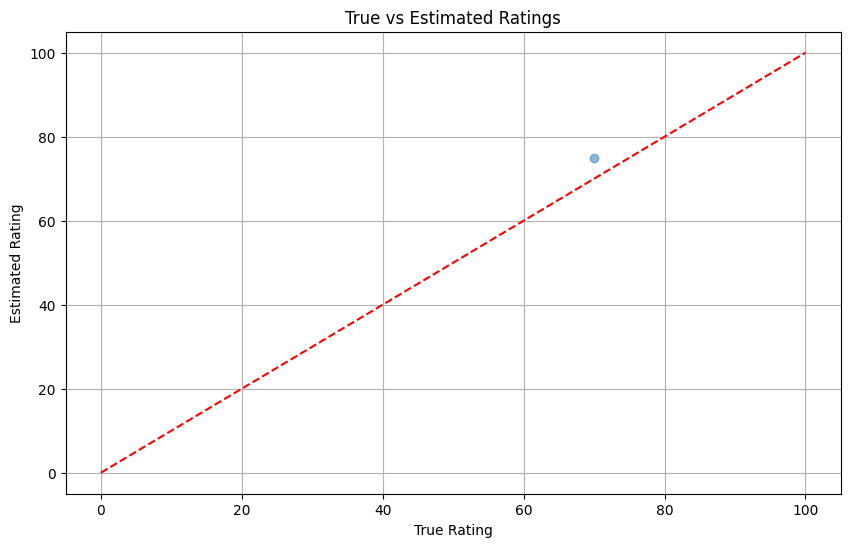

In [8]:
# สร้างแผนภูมิการกระจายของค่าที่ทำนายได้เทียบกับค่าจริง
plt.figure(figsize=(10, 6))
plt.scatter(eval_df['r_ui'], eval_df['est'], alpha=0.5)
plt.plot([0, 100], [0, 100], '--r')
plt.xlabel('True Rating')
plt.ylabel('Estimated Rating')
plt.title('True vs Estimated Ratings')
plt.grid(True)
plt.show()

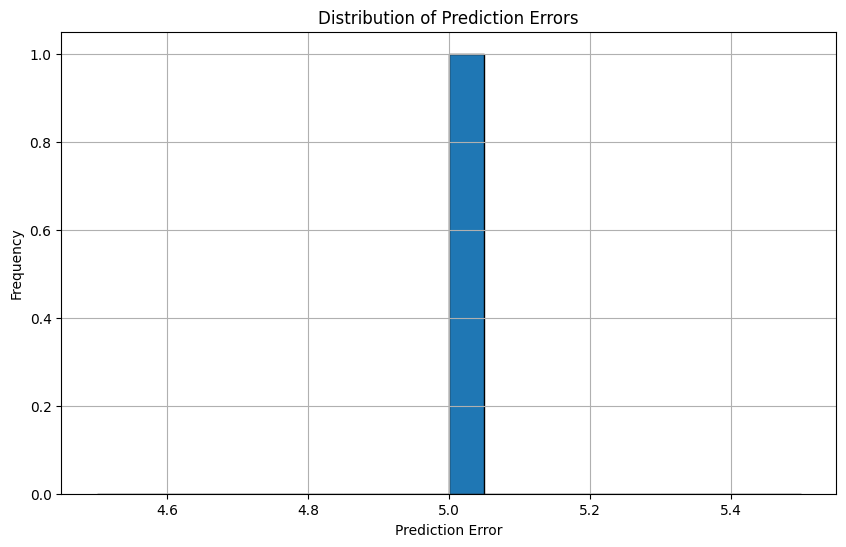

In [9]:
# สร้างแผนภูมิ histogram ของข้อผิดพลาด
plt.figure(figsize=(10, 6))
plt.hist(eval_df['error'], bins=20, edgecolor='k')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.grid(True)
plt.show()